<a href="https://colab.research.google.com/github/sitao-chen/MIDS-1D-Computing-Basics/blob/master/Sitao_Chen_project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Project 1: Digit Classification with KNN


# Intro
---
In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. 
As always, you're welcome to work on the project in groups and discuss ideas over Slack, but <b> please prepare your own write-up (with your own code). </b> To be safe, please credit any sources used.


## Grading
---
 - Make sure to answer every part in every question.
 - There are 5 questions, each worth an equal number of points.
 - Read carefully what is asked including the notes.
 - Additional points may be deducted if:
   - the code is not clean or is not well commented
   - the functions or answers are excessively long

## Requirements:
---
1. Comment your code.
1. Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own.
1. All code must run on colab.research.google.com
1. You should not import any additional libraries.
1. Try and minimize the use of the global namespace (meaning, keep things inside functions).

## Additional reading and notes
---

If you are looking to get started with Tensorflow, you can read through this tutorial: https://www.tensorflow.org/tutorials/keras/classification. It uses a dataset called "fashion_mnist", which is identical in structure to the original digit mnist, but uses images of clothing rather than images of digits. The number of training examples and number of labels is the same. In fact, you can simply replace the code that loads "fashion_mnist" with "mnist" and everything should work fine.

Additionally, if you're interested, check out these links related to digit recognition:

* Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/
* Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

In [ ]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets, svm, metrics
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

In [ ]:
import sklearn
sklearn.__version__

'1.0.2'

Load the data. Notice that the data gets partitioned into training, development, and test sets. Also, a small subset of the training data called mini_train_data and mini_train_labels gets defined, which you should use in all the experiments below, unless otherwise noted.

In [ ]:
# Load the digit data from https://www.openml.org/d/554 or from default local location '~/scikit_learn_data/...'
#X, Y = fetch_openml(name='mnist_784', return_X_y=True, cache=False)
# Use this one on colab.research.google.com
X, Y = fetch_openml(name='mnist_784', as_frame=False, return_X_y=True, cache=False) 
# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print('data shape: ', X.shape)
print('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


In [ ]:
mini_train_data.shape

(1000, 784)

In [ ]:
mini_train_labels.shape

(1000,)

### Question 1: Visualize a select sample of images
---
Show a 10x10 grid that visualizes 10 examples of each digit.

Notes:
* Make the digits nice and big.
* You can use `plt.rc()` for setting the colormap, for example to black and white.
* You can use `plt.subplot()` for creating subplots.
* You can use `plt.imshow()` for rendering a matrix.
* You can use `np.array.reshape()` for reshaping a 1D feature vector into a 2D matrix (for rendering).

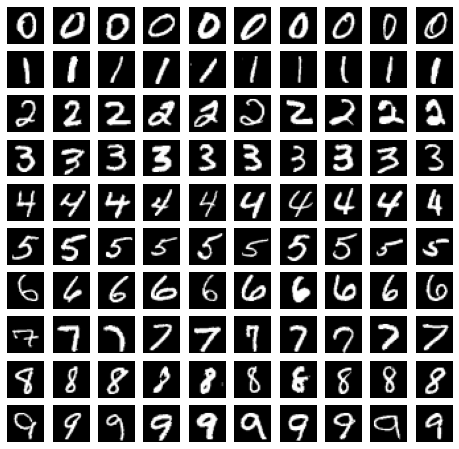

In [ ]:
def Q11(num_examples=10):
  ### STUDENT START ###
    a = []     # Create a new list, and use it to store the first 0's, 1's, 2's - 9's pixel arrays
    for num in range(10):     # Loops thru the 10 digits, 0 - 9
        num=str(num)     # Convert the digit to str
        num_idx = np.where(mini_train_labels == num)     # Find the postions of each digit in the mini_train_label dateset
        img_pos=num_idx[0][:num_examples]     # Take the first and up to num_examples.  Img_pos has 10 positions of each digit
        for digi_img in img_pos:     # Loops thru the mini_train_data using the position numbers to find the image of the digit
            a.append(mini_train_data[digi_img])     # Store the digit info in to a[]

    a = np.asarray(a)  # Create the new sub-set from mini_train_data. a[] only has 10 dataset of each digit (0,1,2,...,9)
    # Plot it
    fig, axs = plt.subplots(nrows=num_examples, ncols=num_examples, figsize=(8, 8))
    for img, ax in zip(a, axs.ravel()):
        ax.imshow(img.reshape((28, 28)), cmap="gray")
        ax.axis("off")

  ### STUDENT END ###

Q11(10)

### Question 2: Evaluating different choices of k
---

1. Produce k-Nearest Neighbors models with k = 1, 3, 5, 7, and 9.  
1. Print the accuracy of each model. 
1. Additionally, only for the 1-Nearest Neighbor model, show the precision, recall, and F1 for each label. 
1. Which digit is the most *difficult* for the 1-Nearest Neighbor model to classify correctly? How did you choose and why?

Notes:
* Train on the mini train set.
* Evaluate performance on the dev set.
* Print only the information asked so it is easy to read and compare.
* You can use `KNeighborsClassifier` to produce a k-nearest neighbor model.
* You can use `classification_report` to get precision, recall, and F1 results.
* Check out what the function "score" does.

In [ ]:
def Q2(k_values):

### STUDENT START ###
    # Iterate thru k values
    for k in k_values:
        # Create KNN model and fit using mini_train_data
        knnmodel=KNeighborsClassifier(n_neighbors=k)
        knnmodel.fit(mini_train_data, mini_train_labels)
        # Model evaluation for dev_data 
        y_predict=knnmodel.predict(dev_data)
        acc=accuracy_score(dev_labels, y_predict)
        print('K=', k, '\tAccuracy: ', acc,'\n')
        if k == 1 :
            print(
                f"Classification report:\n"
                f"{classification_report(dev_labels, y_predict)}\n"
            )
### STUDENT END ###

k_values = [1, 3, 5, 7, 9]
Q2(k_values)

K= 1 	Accuracy:  0.884 

Classification report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       106
           1       0.89      0.98      0.93       118
           2       0.90      0.79      0.84       106
           3       0.93      0.87      0.90        97
           4       0.91      0.85      0.88        92
           5       0.86      0.88      0.87        88
           6       0.92      0.92      0.92       102
           7       0.85      0.94      0.89       102
           8       0.83      0.77      0.80        94
           9       0.80      0.86      0.83        95

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.89      0.88      0.88      1000


K= 3 	Accuracy:  0.876 

K= 5 	Accuracy:  0.882 

K= 7 	Accuracy:  0.877 

K= 9 	Accuracy:  0.875 



Answer to part 4: The digit 8 is the most difficult for the 1-Nearest Neighbor model to classify correctly. As a harmonic mean of precicion and recall, f1-score provides a very good measure of true accuracy. Since the lowest f1-score is for the digit "8", we can say it is the most difficult for 1-NN to recognize.

### Question 3: Examining the importance of training size
---
1. Produce 1-Nearest Neighbor models using training data of various sizes. For example, ```train_data[:train_size]```.
1. Evaluate and show the accuracy achieved by each model.  
1. Show the time needed to: 
  1. Train each model.
  1. Measure the accuracy of each model.
1. What do you see? Is this what you expected to see and why?
1. Plot on the same graph (as a function of training size):
  1. the time needed for training
  1. the time needed for calculating accuracy

Notes:
* Evaluate on the dev set.
* You can use `KNeighborsClassifier` to produce a k-nearest neighbor model.
* You can use `time.time()` to measure elapsed time of operations.

			Accuracy 	Training time 	Calcuation time

train_size = 100 	 0.702 		   0.00 	   0.07
train_size = 200 	 0.791 		   0.00 	   0.06
train_size = 400 	 0.811 		   0.00 	   0.08
train_size = 800 	 0.866 		   0.00 	   0.09
train_size = 1600 	 0.905 		   0.00 	   0.16
train_size = 3200 	 0.927 		   0.01 	   0.26
train_size = 6400 	 0.939 		   0.02 	   0.45
train_size = 12800 	 0.952 		   0.02 	   0.80
train_size = 25600 	 0.963 		   0.04 	   1.52


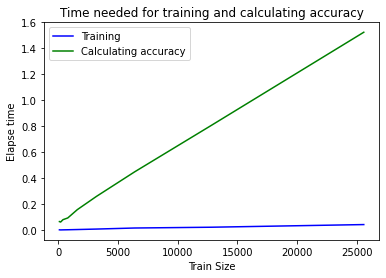

[0.702, 0.791, 0.811, 0.866, 0.905, 0.927, 0.939, 0.952, 0.963]

In [ ]:
def Q3(train_sizes, accuracies, train_times, eval_times):
    print(f"\t\t\tAccuracy \tTraining time \tCalcuation time\n")
### STUDENT START ###
    # Iterate all different size of dataset
    for t_size in train_sizes:
        # create the dataset based on the required size
        t_data, t_labels = train_data[:t_size], train_labels[:t_size]
        # Start the timer for model training
        tr_times = time.time()
        # Create KNN model with k=1 and fit using subset of train_data
        knnmodel=KNeighborsClassifier(n_neighbors=1)
        knnmodel.fit(t_data, t_labels)
        # Stop the timer
        tr_times = time.time() - tr_times
        # Start the timer for calculating the accuracy
        ev_times = time.time()
        # Evaluate on the dev_data dataset
        y_predict=knnmodel.predict(dev_data)
        acc=accuracy_score(dev_labels, y_predict)
        ev_times = time.time() - ev_times
        train_times.append(tr_times)
        eval_times.append(ev_times)
        accuracies.append(acc)
        # Print the result as a table
        print(
            f"train_size = %d" % t_size,
            f"\t% 4.3f" % acc, "\t\t%7.2f" %tr_times, "\t%7.2f" %ev_times
        )
    # Plot the time needed for training and calculating accuracy as a function of training size
    fig, ax = plt.subplots()
    ax.plot(train_sizes, train_times, label='Training', color='blue')
    ax.plot(train_sizes, eval_times, label='Calculating accuracy', color='green')
    legend = ax.legend(loc='upper left')
    plt.xlabel('Train Size')
    plt.ylabel('Elapse time')
    plt.title('Time needed for training and calculating accuracy')
    plt.show()
    return accuracies
### STUDENT END ###

train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600]

accuracies = []
train_times = []
eval_times = []
Q3(train_sizes, accuracies, train_times, eval_times)

Answer to part 4: As the sample size increate, the accuracy is increased while the evaluation takes longer.  This behavior is exprected.  As dataset size incresed, it will take more time for the algorithm to calcualte.

### Question 4: Evaluating if we should obtain additional data
---

In this question we wish to predict what accuracy we would get if we had additional training data.

Our input, our features and labels, are the output from the previous question. Based on the training size and accuracy we got in the previous question, we wish to predict the accuracy we would get if we had larger training sizes.

1. Produce a linear regression model that predicts accuracy of a 1-Nearest Neighbor model given training set size. 
1. Print $R^2$ of the linear regression model.  
1. Print the accuracies predicted for training set sizes 60000, 120000, and 1000000.  
1. Plot on a lineplot graph:
  1. the actual accuracies we obtained in the previous question 
  1. and the accuracies our model predicted we would have gotten.
  1. The X axis is the training set size. 
  1. You can limit the range of X and Y to the range where you have data for both plots. Meaning, in the this question, we want to visualize how good the prediction is.
1. What are two things that are wrong with our model?
1. Apply a transformation to the predictor features and a transformation to the outcome that make the predictions fix these issues. 
1. Show $R^2$ of the improved linear regression model.  
1. Print the accuracies predicted for training set sizes 60000, 120000, and 1000000.  
1. Plot a lineplot graph of both again as before.
  1. Be sure to plot this where the Y axis is accuracy and X axis is training set size, **not the transformed space**!
  1. Choose the range of X and Y to visualize effectively.

Notes:
* Train the linear regression models on all of the (transformed) accuracies estimated in Problem 3.
* Evaluate the linear regression models on all of the (transformed) accuracies estimated in Problem 3.
* You can use `LinearRegression` to produce a linear regression model.
* Remember that the sklearn `fit()` functions take an input matrix X and output vector Y. So, each input example in X is a vector, even if it contains only a single value.
* Hints:
  1. You have two problems here, how well your model fits and predicting *illogical* values of accuracy.
  1. You can look at:
    1. [logit](https://en.wikipedia.org/wiki/Logit): $\frac{1}{1 + e^{-x}} = \frac{e^x}{1+e^x}$ which takes numbers in $\[\infty,-\infty\]$ and outputs numbers in $(0, 1)$.
    1. [logistic](https://en.wikipedia.org/wiki/Logistic_function): $log(\frac{p}{1 - p})$ which takes numbers between $(0, 1)$ and outputs numbers between $\[\infty,-\infty\]$.
    1. It also happens that $x = logistic(p)$ is the same thing as $logit(x)=p$.

R^2 of the linear regression model:  0.418
Train set size :    60000	 Accuracy : 1.236
Train set size :   120000	 Accuracy : 1.637
Train set size :  1000000	 Accuracy : 7.522


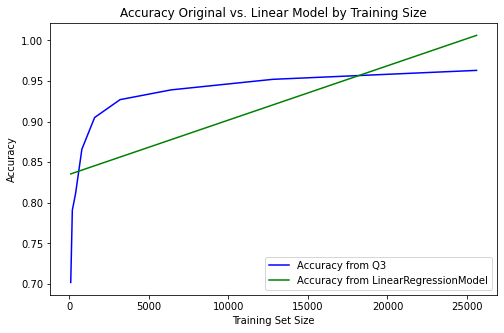

R^2 of the linear regression model:  0.990
Train set size :    60000	 Accuracy : 0.976
Train set size :   120000	 Accuracy : 0.982
Train set size :  1000000	 Accuracy : 0.993


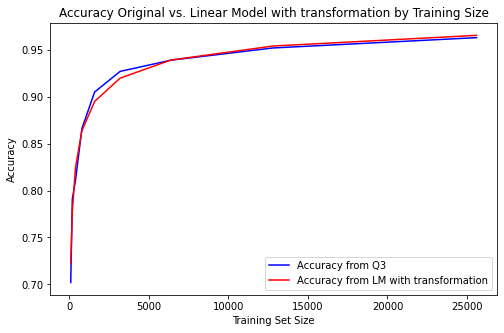

In [ ]:
# Our input, our features and labels, are the output from the previous question.
# Each input example in X is a vector, even if it contains only a single value.

# The train_sizes and accuracies from Q3 are lists, so need to convert them to vector
x_input = np.array(train_sizes).reshape(-1,1)
y_label = np.array(accuracies).reshape(-1,1)
# Carry over the training size and accuracies from Q3
acc_fr_q3 = accuracies
tr_sizes_fr_q3 = train_sizes

def Q4():

### STUDENT START ###

    # Fit lm on training_sizes and accuracies from Q3 (without transformation)
    regr = LinearRegression().fit(x_input, y_label)
    # Predicted accuracy from LM and R^2 from LM
    acc_fr_lm = regr.predict(x_input)
    print("R^2 of the linear regression model: % 4.3f" % regr.score(x_input, y_label))
    # Loop thru different size of dataset to see the accuracy predicated by LM
    for tr_sizes in [60000, 120000, 1000000]:
    # Predict accuracy of a 1-Nearest Neighbor model with different training size using a linear regression model
        predict_accuracy = regr.predict(np.array([tr_sizes]).reshape(-1,1))
        print(
            f"Train set size : % 8d\t" % tr_sizes,
            f"Accuracy :% 4.3f" % predict_accuracy
        )
    # Plot the actual accuracies vs. predicted accuracies from LM
    fig, ax = plt.subplots(figsize = (8,5))
    ax.plot(tr_sizes_fr_q3, acc_fr_q3, label='Accuracy from Q3', color='blue')
    ax.plot(tr_sizes_fr_q3, acc_fr_lm, label='Accuracy from LinearRegressionModel', color='green')
    legend = ax.legend(loc='lower right')
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Original vs. Linear Model by Training Size')
    plt.show()
    
    # Apply tranformation to training data and labels
    transformed_x=np.log(x_input)
    transformed_y=np.log(y_label / (1 - y_label))
    
    # Fit model with transformed data
    transformed_regr = LinearRegression().fit(transformed_x, transformed_y)
    transforemd_predicted_accuracies=transformed_regr.predict(transformed_x)
    print("R^2 of the linear regression model: % 4.3f" % transformed_regr.score(transformed_x, transformed_y))
    for tr_sizes in [60000, 120000, 1000000]:
    # Predict accuracy of a 1-NN model with different transformed training size using a linear regression model
        pred_acc_trans = transformed_regr.predict(np.log(np.array([tr_sizes])).reshape(-1,1))
        print(
            f"Train set size : % 8d\t" % tr_sizes,
            f"Accuracy :% 4.3f" % (np.exp(pred_acc_trans) / (1 + np.exp(pred_acc_trans)))
        )
    fig, ax = plt.subplots(figsize = (8,5))
    ax.plot(tr_sizes_fr_q3, acc_fr_q3, label='Accuracy from Q3', color='blue')
    ax.plot(tr_sizes_fr_q3, (np.exp(transforemd_predicted_accuracies)/(1+np.exp(transforemd_predicted_accuracies))), label='Accuracy from LM with transformation', color='red')
    legend = ax.legend(loc='lower right')
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Original vs. Linear Model with transformation by Training Size')
    plt.show()


### STUDENT END ###

Q4()

Answer to part 5: The first thing wrong with our model is the accuracies are over 1, which don't make sense.  Second thing is that R^2 value is low at 0.418.  The predicted values for accuracy are not very useful either since they are all over 1.00.

### Question 5: Getting to know the confusion matrix.
---

1. Produce a 1-Nearest Neighbor model.
1. Show the confusion matrix. 
1. Which digit does the model most often confuse with which digit? (*for example, the model most often mistakes the digit $1$ as the digit $7$*).
1. Show examples of the misclassified digit.

Notes:
- Train on the mini train set.
- Evaluate performance on the dev set.
- You can use `confusion_matrix()` to produce a confusion matrix.
- No need to calculate the "most confused digits" programmatically.

Confusion Matrix:
 Predicted    0    1   2   3   4   5   6   7   8   9
Actual                                             
0          101    0   1   0   0   0   1   1   2   0
1            0  116   1   0   0   0   0   0   1   0
2            1    4  84   2   2   0   2   4   6   1
3            0    2   0  84   0   6   0   2   3   0
4            0    0   1   0  78   0   0   2   0  11
5            2    0   0   1   1  77   5   0   2   0
6            1    2   1   0   1   2  94   0   1   0
7            0    1   1   0   0   0   0  96   0   4
8            1    5   4   3   1   3   0   1  72   4
9            0    1   0   0   3   2   0   7   0  82

            0   1   2   3   4   5   6   7    ... 992 993 994 995 996 997 998 999
dev_labels   8   9   1   9   6   6   3   7  ...   4   5   5   1   3   4   2   1
y_predict    8   4   1   9   6   6   3   2  ...   7   5   6   1   3   4   2   1

[2 rows x 1000 columns]

The most confused numbers were the number 4 mistaken for the number 9
There were 11 insta

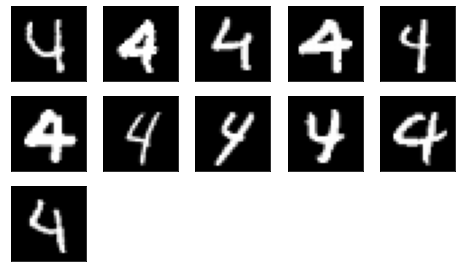

In [ ]:
def Q5():

### STUDENT START ###
    knn=KNeighborsClassifier(n_neighbors=1)
    knn.fit(mini_train_data, mini_train_labels)
    dev_data_predict=knn.predict(dev_data)    
    # Show the confusion matrix
    cm = confusion_matrix(dev_labels, dev_data_predict)
    #print("Confusion Matrix:\n",confusion_matrix(dev_labels, dev_data_predict),"\n")
    # Print the matrix in more clear form
    print("Confusion Matrix:\n", pd.crosstab(pd.Series(dev_labels, name='Actual'), pd.Series(dev_data_predict, name='Predicted')))
    # Show examples of the misclassified digit
    prediction_output=pd.DataFrame(data=[dev_labels,dev_data_predict],index=['dev_labels','y_predict'])
    print("\n",prediction_output)
    # Find the position of "4" in dev_labels dataset, and use it to locate the prediction of "9"
    #The diagonal numbers are the True Positives.  
    #I clear them to leave me with the false negatives.
    np.fill_diagonal(cm, 0)

    #Select the highest ocurrence of false negatives.  
    pos_row, pos_col = np.unravel_index(np.argmax(cm), cm.shape)

    print("\nThe most confused numbers were the number", pos_row, "mistaken for the number", pos_col)

    confused_set = dev_data[(dev_labels == str(pos_row)) & (dev_data_predict == str(pos_col))]
    print("There were", confused_set.shape[0], "instances of these mistakes.")

    #Plot the set of incorrect numbers:
    plt.figure(figsize = (8,8))

    i = 0 #iterates through the dataset
    j = 1 #iterates up the subplot structure

    #iterate through the mini training set
    while i < confused_set.shape[0]:
        a = np.reshape(confused_set[i], (28, 28))
        plt.subplot(5,5,j)
        plt.imshow(a, cmap = 'gray')
        ax = plt.gca()
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        j+=1
        i+=1    
### STUDENT END ###

Q5()


Answer to part 3: The model most often confuses the digit 4 with digit 9